# Logo Recognition Algorithm with Kaggle Logos Training Data

We chose to use data copied from: ...



The brands included in the dataset are: 

### Step 1: Loading Dataset & EDA 

#### **Reflections in Step 1 (REMOVE LATER)**

#### Evaluating whether to have many categories or just one or few
When going about choosing to have a few samples from each category or many samples from the same category, we chose to rather go for many samples for one category's logos.

In this choice we evaluated several factors:

+ Do we want our research to focus on identifying that **particular industry's logos**, or are we more interested in differentiating among several industries. And when focusing on identifying logos within a particular industry, what other data do we need to train the model on?

+ To answer the second question we then evaluated, in which setting would we like to see the algorithm applied? At the moment we are taking an isolated approach where we evaluate various algorithms performance to classify the logo. 

+ One could also examine the possibility to do a **recognition/detection algorithm**, but then it would evidently be easier to focus on one solely. So if the goal is to detect your own company logo in the real world, from photos and images, this could be a suitable way to go about it. --> maybe more practical?

+ Running time and computer capacity.

#### Bias in Class numbers and samples

We quickly adress potential bias from skewed nr of samples from different classes. Thus, from each brand we choose a max of 10 pictures from each, which we further augment, so we have the same nr of samples for each brand.

**OBS! In a classification task the nature of the task is to use it to differ among many brands. Nevertheless, our training data will naturally miss many logos, thus not being able to identify these, and will thus give wrong prediction.**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras 
#import tensorflow_addons as tfa #have some issues loading this package
import tarfile
import os
from PIL import Image
import PIL.ImageEnhance as ImageEnhance
import requests
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import torchvision
import math
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, BatchNormalization

In [3]:
folder_path = '/Users/veronicalarsson/Downloads/datasetcopy/trainandtest/train/Medical/'
label_path = '/Users/veronicalarsson/Downloads/datasetcopy/List/train_images.txt'

In [4]:
"""Loading (this function looks at a specified nr of photos from each folder)"""

#add functionality to select which folders you want to include

def load_images_from_folder(folder_path, max_images_per_folder=200):
    """
    Load images from a folder and return a DataFrame containing 
    image filenames, images, sizes, aspect ratios, number of channels, 
    and labels derived from the folder names.
    """
    images = []
    label_encoder = LabelEncoder()

    # Recursively traverse through the folder structure
    for root, dirs, files in os.walk(folder_path):
        num_images_in_folder = 0  # Initialize the counter for images in the current folder
        folder_label = os.path.basename(root)  # Use the last part of the root as the label

        for filename in files:
            # Check if the maximum number of images per folder has been reached
            if num_images_in_folder >= max_images_per_folder:
                break  # Stop processing files in the current folder
            
            # Get the full path of the file
            file_path = os.path.join(root, filename)
            
            # Check if the file is an image
            if any(filename.endswith(extension) for extension in ['.jpg', '.jpeg', '.png', '.gif']):
                try:
                    with Image.open(file_path) as img: # Load the image using PIL (Python Imaging Library)

                        # Append the image data to the list
                        images.append({
                            'Filename': filename, 
                            'Image': img.resize(img.size), #cannot open example picture without using resize method = Image object is now of type <PIL.Image.Image... instead of PIL.JpegImagePlugIn.JpegImageFile... (latter could not open)
                            'Size': img.size,
                            'Aspect Ratio': img.width / img.height, 
                            'Channels': len(img.getbands()),
                            'Label': folder_label  # Use the folder name as the label
                        })
                        num_images_in_folder += 1  # Increment the counter

                except Exception as e:
                    print(f"Error loading image '{filename}': {e}")
    
    images_df = pd.DataFrame(images) # Convert the list of dictionaries to a DataFrame
    images_df['Label Encoded'] = label_encoder.fit_transform(images_df['Label']) #Encode labels

    return images_df

image_df = load_images_from_folder(folder_path)

In [5]:
"""Run to get an overview of the data"""

# Get an overview of the number of images per label
labelinfo = image_df['Label'].value_counts() 
print('About the Distribtion of Labels:')
print('The number of different brands is', len(labelinfo))
print('The number of images per brand ranges from',labelinfo.min(),'to', labelinfo.max())
print('The average is',labelinfo.mean().round(),'and the median is', labelinfo.median())
#print("\nDetailed overview of number of images per label:\n \n", labelinfo)

# Get an overivew of image characteristics (size, channels) in the dataset
print('\n')
print('About the Images in the Dataset:')

imagesizes = image_df['Size'].value_counts()
print('The number of different sizes is', len(imagesizes))
#print('Image size(s) in the dataset:', imagesizes.unique) #improve

imagecolors = image_df['Channels'].value_counts()
print('There is only one color scheme:', len(imagecolors)==1)
#print('Color scheme(s) in the dataset:', imagecolors.unique) #improve

# Get an overivew of the first rows of df
print('\n')
print('Quick view of dataframe:')
image_df.head()

About the Distribtion of Labels:
The number of different brands is 48
The number of images per brand ranges from 50 to 97
The average is 71.0 and the median is 69.0


About the Images in the Dataset:
The number of different sizes is 1
There is only one color scheme: True


Quick view of dataframe:


,Filename,Image,Size,Aspect Ratio,Channels,Label,Label Encoded
0,48.jpg,<PIL.Image.Image image mode=RGB size=256x256 a...,"(256, 256)",1.0,3,Lacto,22
1,49.jpg,<PIL.Image.Image image mode=RGB size=256x256 a...,"(256, 256)",1.0,3,Lacto,22
2,8.jpg,<PIL.Image.Image image mode=RGB size=256x256 a...,"(256, 256)",1.0,3,Lacto,22
3,9.jpg,<PIL.Image.Image image mode=RGB size=256x256 a...,"(256, 256)",1.0,3,Lacto,22
4,14.jpg,<PIL.Image.Image image mode=RGB size=256x256 a...,"(256, 256)",1.0,3,Lacto,22


In [6]:
def display_image_samples(df, axistitle = 'Label', num_samples=10):
    """
    Display a specified number of image samples from a DataFrame in a grid format.
    
    Parameters:
    df (DataFrame): DataFrame containing image data.
    num_samples (int): Number of image samples to display.
    """
    # Determine the number of rows and columns in the grid
    num_columns = 5  # Set a fixed number of columns or make it dynamic based on the input
    num_rows = math.ceil(num_samples / num_columns)
    
    # Create a subplot grid
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 3))
    axes = axes.flatten()  # Flatten the axes array for easier iteration

    # Plot each image in the grid
    for i in range(num_samples):
        img = df['Image'].iloc[i]
        # Convert the PIL Image to a numpy array if it's not already an array
        if not isinstance(img, np.ndarray):
            img = np.array(img)
        
        ax = axes[i]
        ax.imshow(img, interpolation="lanczos")
        ax.axis("off")  # Hide the axes
        ax.set_title(f"{df[axistitle].iloc[i]}")

    # Turn off axes for any unused subplots
    for j in range(num_samples, num_rows * num_columns):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

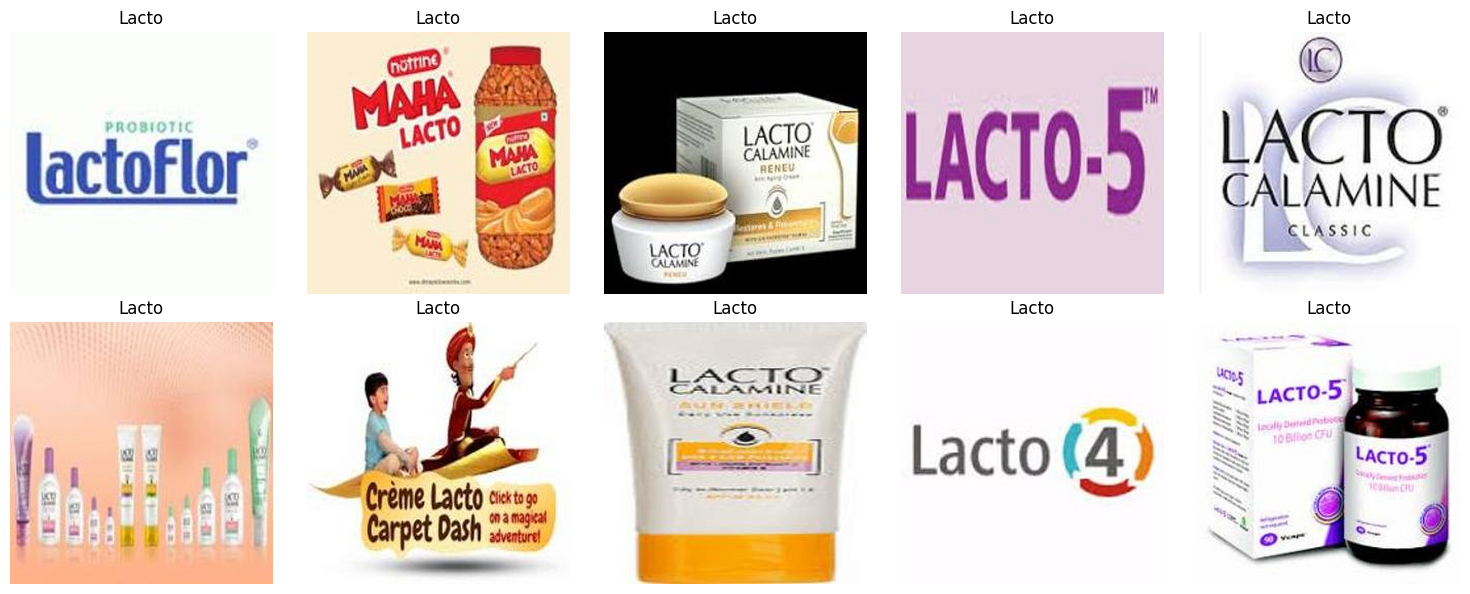

In [7]:
"""Run to display sample of images with labels"""
display_image_samples(image_df, num_samples=10)

### Step 2: Data Preparation & Augmentation

#### Data Augmentation
Data augmentation is a technique used in machine learning and deep learning to artificially increase the size of a training dataset by applying various transformations to the existing data. The goal is to enhance the model's generalization ability, robustness, and performance by exposing it to a more diverse set of examples during training. This technique is particularly useful when the available dataset is limited.

Common data augmentation techniques include:

1. **Flip:** Flipping images horizontally or vertically.
2. **Zoom:** Zooming in or out of images.
3. **Brightness and Contrast Adjustment:** Changing the brightness and contrast of images.
4. **Noise Injection:** Adding random noise to images.
5. **Color Jittering:** Adjusting the color values of images.

For example, in image classification tasks, if you have a dataset of cat images, you can apply data augmentation to generate variations of the same images by rotating, flipping, zooming, or changing their colors. This way, the model sees different perspectives of the same data during training, which can help it become more robust to variations and improve its performance on new, unseen data.

In deep learning frameworks and libraries, there are often built-in tools or functions for applying data augmentation during the training process. This allows practitioners to easily incorporate these transformations into their pipelines without manually creating augmented datasets.

#### Comments to prepare_for_training function

**Shuffling**: Randomly shuffles the order of the dataset’s items to ensure the model doesn’t learn anything from the order of the data. This is very important for our dataset where the images are loaded in order.

**Batching**: After shuffling, the data is grouped into batches of batch_size.

**Prefetching**: This is a performance optimization that overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. This reduces the step time to the maximum (rather than the sum) of the training and time taken to extract the data.

In [32]:
ds = image_df[['Image', 'Label Encoded']] # Limiting dataset to only use Features and Labels (encoded)

In [35]:
def preprocess_and_augment_image(image):
    """
    Convert a PIL image to a TensorFlow tensor, apply preprocessing and augmentation, and return as a numpy array.
    
    Parameters:
    image (PIL.Image): The input image to preprocess and augment.
    
    Returns:
    numpy.ndarray: The augmented image as a numpy array.
    """
    # Convert the PIL Image to a numpy array
    image_array = np.array(image)

    # Convert the numpy array to a TensorFlow tensor and normalize the pixel values (Normalization helps in converging quicker during training)
    image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32) / 255.0

    # Resize the image to the desired size for the model (224x224 is common for models like VGG, ResNet)
    image_tensor = tf.image.resize(image_tensor, [224, 224])

    # Data augmentation
    image_tensor = tf.image.random_flip_left_right(image_tensor) # Randomly flip the image horizontally, providing more variation in the dataset

    image_tensor = tf.image.random_flip_up_down(image_tensor) # Randomly flip the image vertically, providing more variation in the dataset

    image_tensor = tf.image.random_crop(image_tensor, size=[int(224*0.8), int(224*0.8), 3]) # Randomly crop the image to 80% of its size and then resize it back to 224x224 (zooming in and out of the images)
    image_tensor = tf.image.resize(image_tensor, [224, 224])

    image_tensor = tf.image.random_brightness(image_tensor, max_delta=0.2) # Adjust the brightness of the image by a random factor of up to ±20%

    image_tensor = tf.image.random_contrast(image_tensor, lower=0.8, upper=1.2) # Adjust the contrast of the image randomly between 80% to 120% of the original contrast

    noise = tf.random.normal(shape=tf.shape(image_tensor), mean=0.0, stddev=0.1, dtype=tf.float32) # Inject random noise to the image to simulate real-world scenarios
    image_tensor = tf.add(image_tensor, noise)
    
    image_tensor = tf.image.random_hue(image_tensor, max_delta=0.08) # Randomly adjust the hue of the image by a factor of ±8%

    image_tensor = tf.image.random_saturation(image_tensor, lower=0.6, upper=1.6) # Randomly adjust the saturation of the image, altering the intensity of the colors

    return np(image_tensor)

def prepare_dataframe(df):
    """
    Process all images for augmentation and prepare a DataFrame with processed images.
    
    Parameters:
    df (DataFrame): A DataFrame containing the 'Image' column with PIL images and a 'Label Encoded' column.
    
    Returns:
    DataFrame: A DataFrame with each image pixel in separate columns, along with the encoded label.
    """
    processed_images = [preprocess_and_augment_image(img) for img in df['Image']]
    processed_labels = [tf.convert_to_tensor(label, dtype=tf.int32) for label in df['Label Encoded']] #must be tensors, same format as images, to be used in model
    
    # Create a DataFrame  storing tensors
    image_df = pd.DataFrame({
        'Image': processed_images,
        'Label Encoded': processed_labels
    })

    return image_df

In [36]:
"""Run to Preprocess & Augment Images. Run time: 12.7s"""
model_data = prepare_dataframe(ds)

### Step 3: Splitting Test & Training Data

In [41]:
"""Creates training and test sets (0.1s)"""

# # Split the DataFrame into features (pixels) and labels
features = model_data['Image'].values  # Flattened and scaled features (pixel values)
labels = model_data['Label Encoded'].values  # Labels

# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Example conversion before splitting (if starting from tensors)
features = np.array([x.numpy() if isinstance(x, tf.Tensor) else x for x in features])
labels = np.array([y.numpy() if isinstance(y, tf.Tensor) else y for y in labels])

# Now, splitting should be safe
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


# Display the shapes of the resulting splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2708, 224, 224, 3)
X_test shape: (677, 224, 224, 3)
y_train shape: (2708,)
y_test shape: (677,)


### Step 4: Building Models for Image Classification

1. **Model_1**: The most basic model to be applied for image classification tasks

2. **Model_2**: Advancing the basic model

3. **Model_3**: 

Model from New Efficient CNN:

In [38]:
#CNN Model
cnn_model_1 = Sequential()

# Convolutional layers with Batch Normalization
cnn_model_1.add(Conv2D(kernel_size=(3, 3), filters=64, input_shape=(256, 256, 3), activation='relu'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model_1.add(Conv2D(kernel_size=(3, 3), filters=128, activation='relu'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model_1.add(Conv2D(kernel_size=(3, 3), filters=256, activation='relu'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout layer
cnn_model_1.add(Dropout(0.5))

# Global average pooling layer
cnn_model_1.add(GlobalAveragePooling2D())

# Output layer
cnn_model_1.add(Dense(27, activation='softmax'))

cnn_model_1.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 254, 254, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 125, 125, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 60, 60, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 27)             │         6,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,547 (1.45 MB)

 Trainable params: 378,651 (1.44 MB)

 Non-trainable params: 896 (3.50 KB)

In [42]:
#Compile the model 
cnn_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Train the model for 100 epochs
H = cnn_model_1.fit(X_train, y_train, epochs=2)

print("Evaluate on test data")

results = cnn_model_1.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Epoch 1/2


2024-04-21 16:59:55.124857: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 46 which is outside the valid range of [0, 27).  Label values: 44 7 16 19 16 18 8 17 31 37 9 37 16 40 44 7 46 33 43 4 27 34 37 16 25 35 12 12 39 42 5 43
2024-04-21 16:59:55.126684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Received a label value of 46 which is outside the valid range of [0, 27).  Label values: 44 7 16 19 16 18 8 17 31 37 9 37 16 40 44 7 46 33 43 4 27 34 37 16 25 35 12 12 39 42 5 43
	 [[{{function_node __inference_one_step_on_data_83871781}}{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/traitlets/config/application.py", line 1077, in launch_instance

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 618, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1951, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 84, in _run

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 529, in dispatch_queue

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 518, in process_one

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 424, in dispatch_shell

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/Users/veronicalarsson/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/var/folders/pz/8dk8k_ld1bl3f5d2d_5br0300000gn/T/ipykernel_6253/311451702.py", line 5, in <module>

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 325, in fit

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 118, in one_step_on_iterator

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 106, in one_step_on_data

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 322, in compute_loss

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 605, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 641, in call

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/losses/loss.py", line 42, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/losses/losses.py", line 22, in call

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/losses/losses.py", line 1714, in sparse_categorical_crossentropy

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/ops/nn.py", line 1554, in sparse_categorical_crossentropy

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 633, in sparse_categorical_crossentropy

Received a label value of 46 which is outside the valid range of [0, 27).  Label values: 44 7 16 19 16 18 8 17 31 37 9 37 16 40 44 7 46 33 43 4 27 34 37 16 25 35 12 12 39 42 5 43
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_83871896]